[arma1](https://assaeunji.github.io/statistics/2021-09-08-arimapdq/)  

In [ ]:
# 모델 저장 함수
def save_model(model, filename):
    with open(filename, 'wb') as pkl:
        pickle.dump(model, pkl)

# 모델 로드 함수
def load_model(filename):
    with open(filename, 'rb') as pkl:
        return pickle.load(pkl)

# ARIMA 모델 피팅 및 저장
def fit_and_save_model(series, i):
    model_filename = f'arima_model_{i}.pkl'
    
    # 기존에 저장된 모델 파일이 있는지 확인
    try:
        model = load_model(model_filename)
        print(f"Model {i} loaded successfully.")
    except FileNotFoundError:
        print(f"Model {i} not found. Fitting new model.")
        model = auto_arima(series, test='adf', D=0, seasonal=False, suppress_warnings=True, n_jobs=-1)
        save_model(model, model_filename)
        print(f"Model {i} saved successfully.")
    
    return model

# 모델을 사용하는 코드
start_time = time.time()

for i in range(1, 101):
    # 모델 로드 또는 새로운 모델 학습 및 저장
    model = fit_and_save_model(df_train[f'heart_rate{i}'], i)
    p, d, q = model.order
    arima_model = ARIMA(df_train[f'heart_rate{i}'], order=(p, 0, q))
    result = arima_model.fit()

    # 예측 실행
    start_idx = 16380
    end_idx = start_idx + len(df_test)
    forecast = result.get_prediction(start=start_idx, end=end_idx, dynamic=True)
    forecast_ci = forecast.conf_int()

    # 예측 결과를 데이터프레임에 저장
    df_test[f'lower_{i}'] = forecast_ci.iloc[:, 0]
    df_test[f'upper_{i}'] = forecast_ci.iloc[:, 1]
    df_test[f'pred_y{i}'] = np.where((df_test[f'heart_rate{i}'] < df_test[f'lower_{i}']) | (df_test[f'heart_rate{i}'] > df_test[f'upper_{i}']), 1, 0)

end_time = time.time()
time_diff = str(timedelta(seconds=end_time - start_time))
print('코드 실행 시간:', time_diff)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from performance import performance
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
import time
from datetime import timedelta
import pickle
import matplotlib
import matplotlib.font_manager as fm
# fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = 'C:/Windows/Fonts/gulim.ttc' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
import matplotlib.dates as mdates

In [2]:
import pandas as pd
tj = pd.read_csv('../data/heart_rate_tj.csv')

In [9]:
len(tj)

2390

<Figure size 640x480 with 0 Axes>

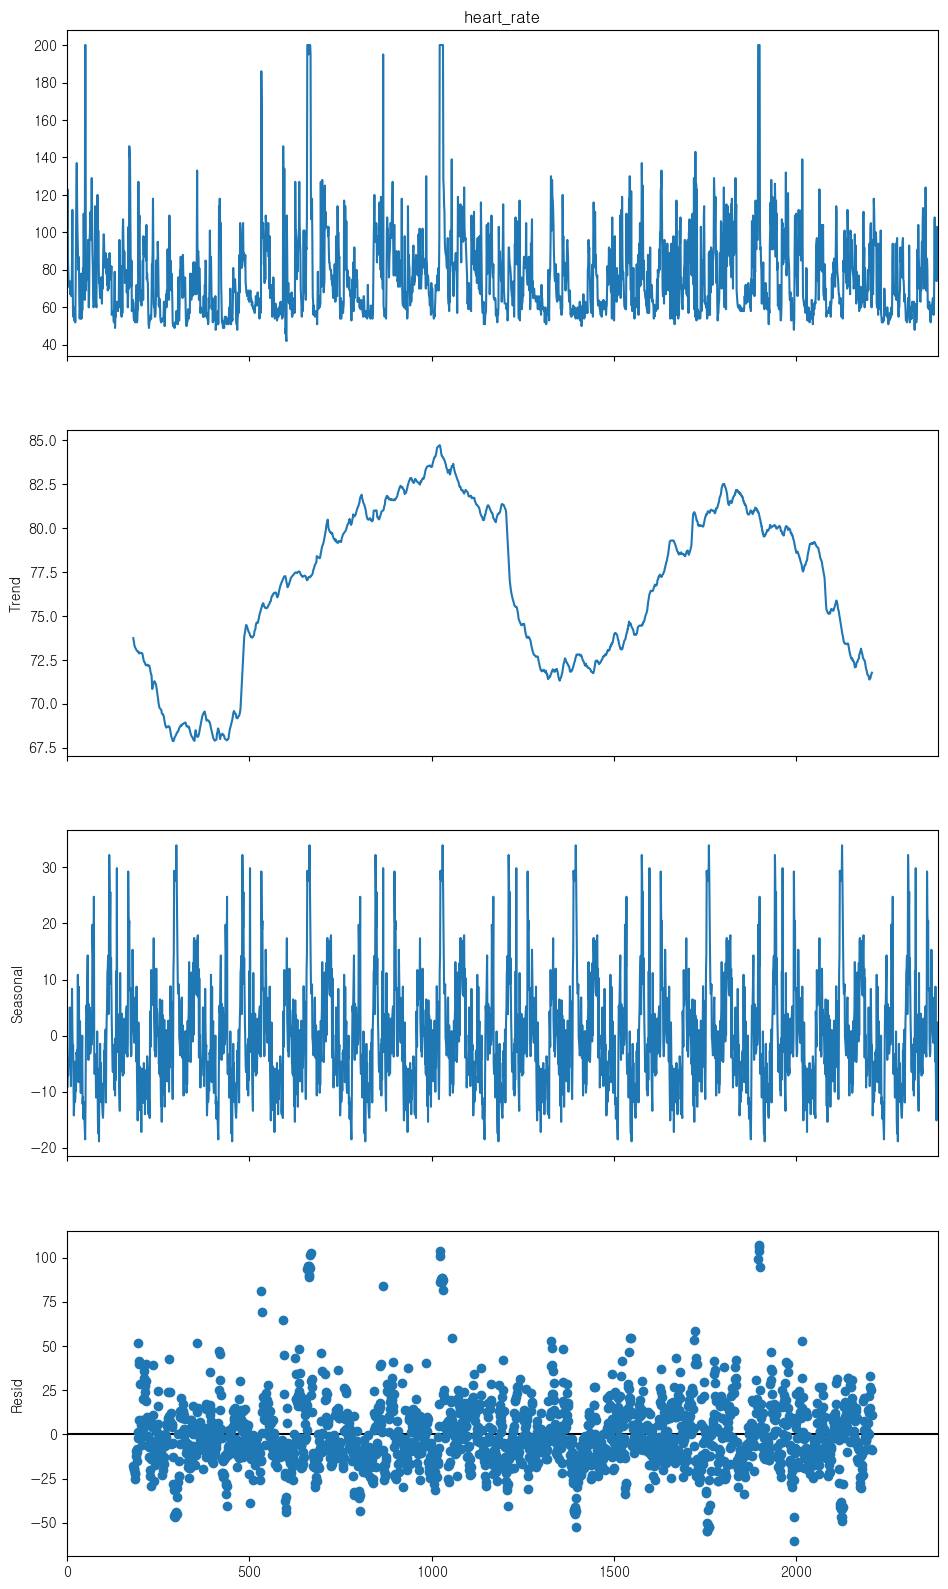

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(tj['heart_rate'], period=365)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(10,18)

plt.show()

# ADF test

# 로그정규분포 - 신뢰구간 95%

## 1. 보통 심박

In [97]:
df = pd.read_csv('../data/로그정규/보통심박.csv', encoding='cp949')

df.head(2)

,time,heart_rate1,event1,heart_rate2,event2,heart_rate3,event3,heart_rate4,event4,heart_rate5,...,heart_rate96,event96,heart_rate97,event97,heart_rate98,event98,heart_rate99,event99,heart_rate100,event100
0,2024-01-01 09:00:00,85.689072,0,83.619243,0,100.388465,1,68.436331,0,89.053103,...,79.909588,0,78.703384,0,74.131167,0,85.103926,0,104.703351,1
1,2024-01-01 09:01:00,70.799472,0,80.284777,0,79.134970,0,86.997365,0,89.120294,...,81.876244,0,70.098775,0,77.329517,0,80.226264,0,60.309250,0


In [98]:
# 분석
df_copy = df.copy()

# 데이터를 df_train과 df_test로 분할
df_train = df_copy[:16380]
df_test = df_copy[16380:]

print(df_train.shape)
print(df_test.shape)

(16380, 201)
(7800, 201)


In [26]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series):
    result = adfuller(series)  # adf 검정
    if result[1] <= 0.05:  # p-value가 0.05 이하인 경우 정상성 만족
        return True
    else:
        return False

# 정상성 확인 및 결과 출력
non_stationary_variables = []  # 정상성을 만족하지 않는 변수들을 저장할 리스트

for i in range(1, 101):
    column_name = f'heart_rate{i}'
    # 함수 호출 결과를 바탕으로 정상성 검정
    if not adfuller_test(df_train[column_name]):
        non_stationary_variables.append(column_name)

# 정상성을 만족하지 않는 변수들 출력
if non_stationary_variables:
    print("정상성을 만족하지 않는 변수들:")
    for variable in non_stationary_variables:
        print(variable)
else:
    print("모든 변수가 정상성을 만족합니다.")

모든 변수가 정상성을 만족합니다.


### 보통 모델 저장

In [100]:
start_time = time.time()

for i in range(1, 101):
    # Select the optimal p and q values for ARIMA model
    model = auto_arima(df_train[f'heart_rate{i}'],test='adf',D=0 , ,seasonal=False, suppress_warnings=True, n_jobs=-1)
    p, d, q = model.order
    print(p,q)
    # ARIMA 모델 학습
    model = ARIMA(df_train[f'heart_rate{i}'], order=(p, 0, q))
    result = model.fit()

    start_idx = 16380  # 테스트 데이터셋의 시작 인덱스
    end_idx = 16380 + len(df_test)  # 테스트 데이터셋의 끝 인덱스

    forecast = result.get_prediction(start=start_idx, end=end_idx, dynamic=True)

    # 신뢰구간과 예측값 할당
    forecast_ci = forecast.conf_int()

    # 데이터프레임에 신뢰구간 추가
    df_test[f'lower_{i}'] = forecast_ci.iloc[:, 0]
    df_test[f'upper_{i}'] = forecast_ci.iloc[:, 1]

    # 'pred_y{i}' 열이 이미 존재하는 경우 삭제하고 다시 추가 (insert 메서드 사용)
    if f'pred_y{i}' in df_test.columns:
        df_test.drop(columns=[f'pred_y{i}'], inplace=True)

    # 'pred_y{i}' 열을 'event{i}' 뒤에 생성
    df_test.insert(df_test.columns.get_loc(f'event{i}') + 1, f'pred_y{i}', np.where((df_test[f'heart_rate{i}'] < df_test[f'lower_{i}']) | (df_test[f'heart_rate{i}'] > df_test[f'upper_{i}']), 1, 0))

    # 'pred{i}', 'lower_{i}', 'upper_{i} 삭제
    if f'pred{i}' in df_test.columns:
        df_test.drop(columns=[f'pred{i}'], inplace=True)
    if f'lower_{i}' in df_test.columns:
        df_test.drop(columns=[f'lower_{i}'], inplace=True)
    if f'upper_{i}' in df_test.columns:
        df_test.drop(columns=[f'upper_{i}'], inplace=True)


end_time = time.time()
time_diff = end_time - start_time

time_diff = str(timedelta(seconds=time_diff))

print('코드 실행 시간: {}'.format(time_diff))

코드 실행 시간: 0:34:53.057547


In [103]:
df_test.head(2)

,time,heart_rate1,event1,pred_y1,heart_rate2,event2,pred_y2,heart_rate3,event3,pred_y3,...,pred_y97,heart_rate98,event98,pred_y98,heart_rate99,event99,pred_y99,heart_rate100,event100,pred_y100
16380,2024-01-22 09:00:00,77.160495,0,0,79.791644,0,0,79.702605,0,0,...,0,69.473862,0,0,76.836609,0,0,79.421549,0,0
16381,2024-01-22 09:01:00,84.525611,0,0,80.039418,0,0,70.064453,0,0,...,0,72.799685,0,0,77.884151,0,0,88.607093,0,0


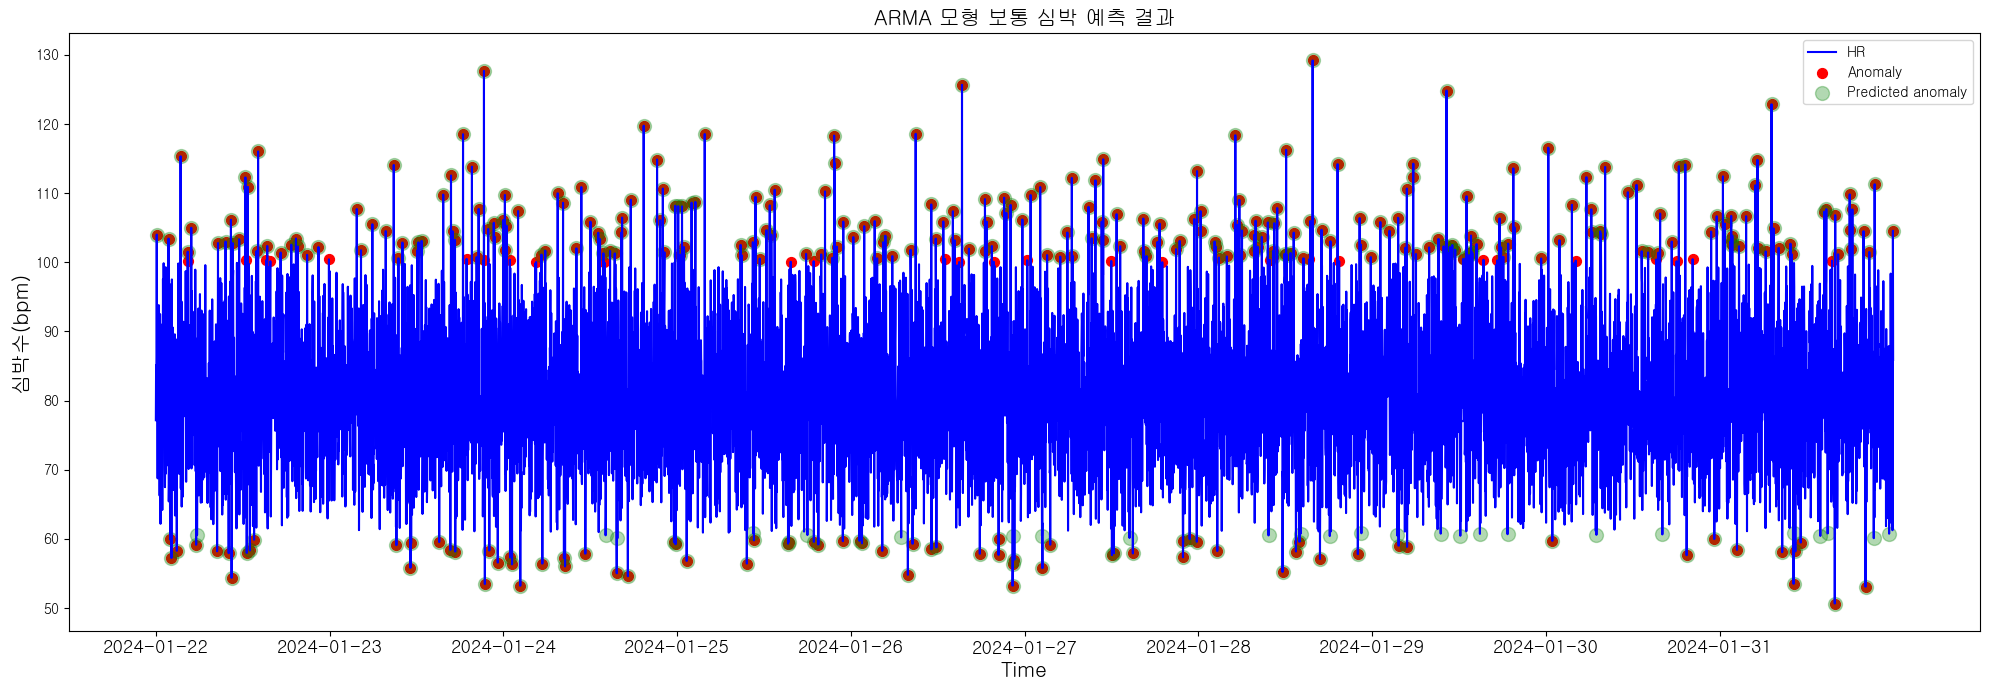

In [122]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# ... df_test를 불러오고 필요한 데이터 처리를 하는 코드 ...

# 가정: 'time' 열이 이미 datetime 타입으로 변환되었음
# 예: df_test['time'] = pd.to_datetime(df_test['time'])

# 데이터의 시작과 끝 날짜를 기준으로 날짜 범위를 생성
date_range = pd.date_range(start=df_test['time'].iloc[0], end=df_test['time'].iloc[-1], freq='D')

# 날짜 범위에 대한 인덱스를 찾음
date_ticks = [df_test[df_test['time'] == date].index[0] for date in date_range]

plt.figure(figsize=(20,7))
plt.plot(df_test['heart_rate1'], label='HR', color='blue')  # 'time' 열을 제외하고 인덱스에 따라 플롯

# 실제 이상치 시각화
plt.scatter(df_test[df_test['event1'] == 1].index, 
            df_test[df_test['event1'] == 1]['heart_rate1'],
            color='red', label='Anomaly', s=50)

# 예측된 이상치 시각화
plt.scatter(df_test[df_test['pred_y1'] == 1].index, 
            df_test[df_test['pred_y1'] == 1]['heart_rate1'],
            color='green', label='Predicted anomaly', s=100, alpha=0.3)

# x축 눈금과 레이블 설정
plt.xticks(ticks=date_ticks, labels=[date.strftime('%Y-%m-%d') for date in date_range], fontsize=13)

plt.xlabel('Time', fontsize=15, fontweight='bold')
plt.ylabel('심박수(bpm)', fontsize=15, fontweight='bold')
plt.title('ARMA 모형 보통 심박 예측 결과', fontsize=15, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()


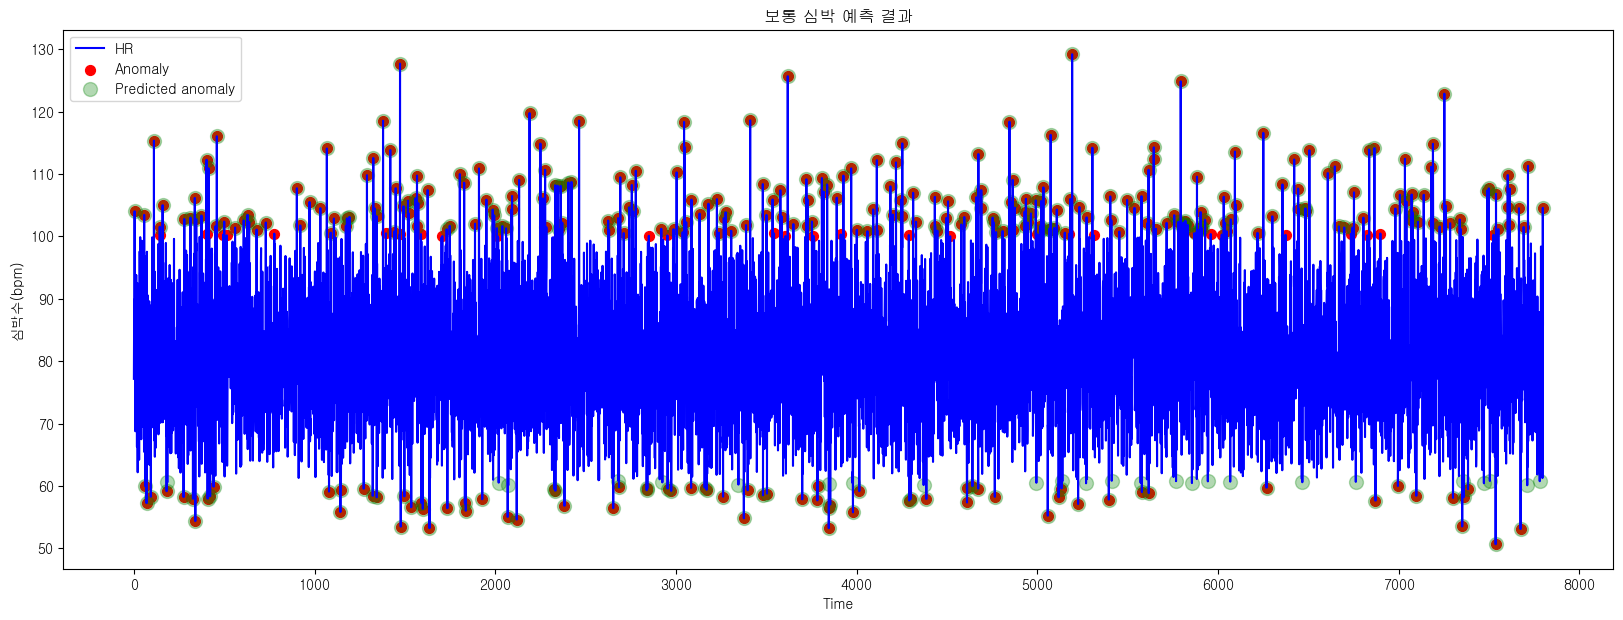

In [114]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(df_test)), df_test['heart_rate1'], label='HR', color='blue')
anomalies = df_test[df_test['event1'] == 1]

# 실제 이상치 시각화
plt.scatter(np.arange(len(df_test))[df_test['event1'] == 1], 
            df_test[df_test['event1'] == 1]['heart_rate1'],
            color='red', label='Anomaly', s=50)

# 예측된 이상치 시각화
plt.scatter(np.arange(len(df_test))[df_test['pred_y1'] == 1], 
            df_test[df_test['pred_y1'] == 1]['heart_rate1'],
            color='green', label='Predicted anomaly', s=100, alpha=0.3)

plt.xlabel('Time')
plt.ylabel('심박수(bpm)')
plt.title('보통 심박 예측 결과')
plt.legend()
plt.show()

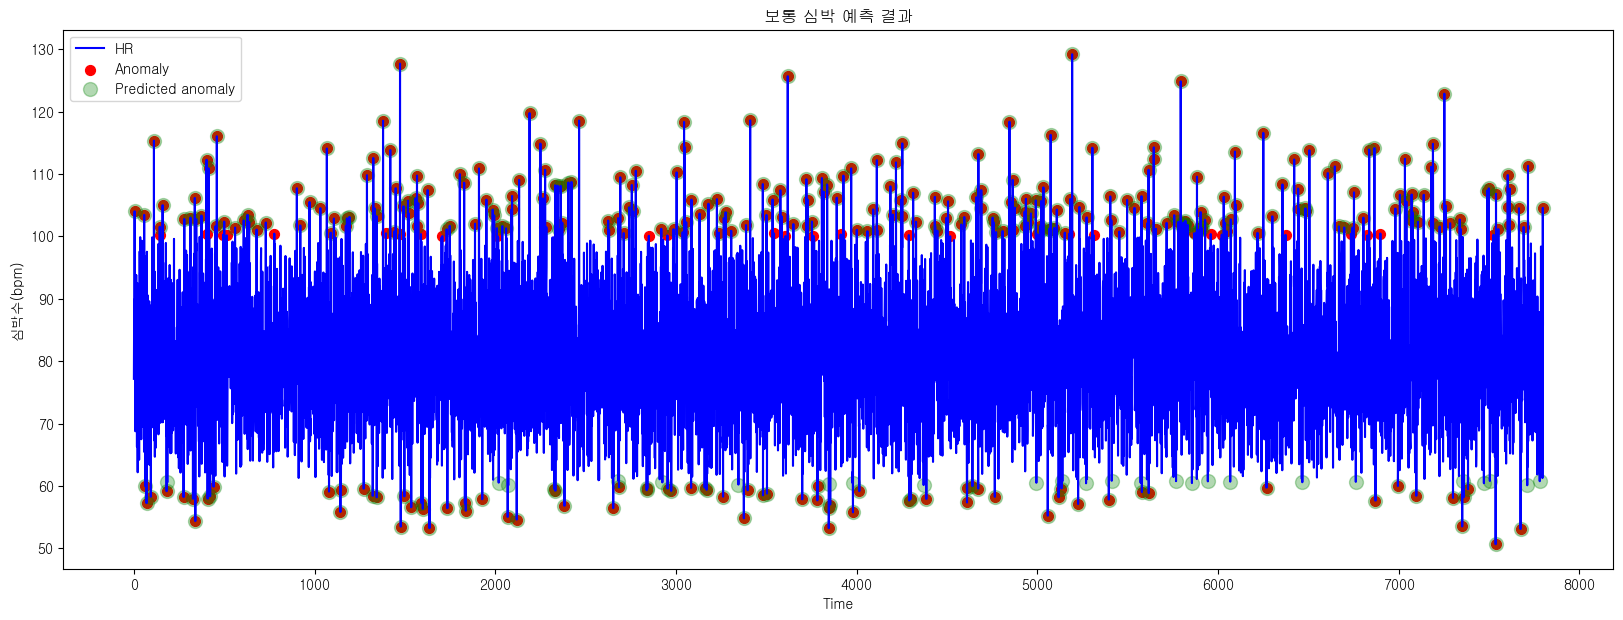

In [104]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(df_test)), df_test['heart_rate1'], label='HR', color='blue')
anomalies = df_test[df_test['event1'] == 1]
# 실제 이상치 시각화
plt.scatter(np.arange(len(df_test))[df_test['event1'] == 1], 
            df_test[df_test['event1'] == 1]['heart_rate1'],
            color='red', label='Anomaly', s=50)

# 예측된 이상치 시각화
plt.scatter(np.arange(len(df_test))[df_test['pred_y1'] == 1], 
            df_test[df_test['pred_y1'] == 1]['heart_rate1'],
            color='green', label='Predicted anomaly', s=100, alpha=0.3)

plt.xlabel('Time')
plt.ylabel('심박수(bpm)')
plt.title('보통 심박 예측 결과')
plt.legend()
plt.show()

In [30]:
result = pd.DataFrame()

for i in range(1,101):

    TP = len(df_test[(df_test[f'event{i}']==1)&(df_test[f'pred_y{i}']==1)])
    TN = len(df_test[(df_test[f'event{i}']==0)&(df_test[f'pred_y{i}']==0)])
    FN = len(df_test[(df_test[f'event{i}']==1)&(df_test[f'pred_y{i}']==0)])
    FP = len(df_test[(df_test[f'event{i}']==0)&(df_test[f'pred_y{i}']==1)])


    result_i = performance(TP=TP, TN=TN, FP=FP, FN=FN, BETA=1)
    
    result = pd.concat([result, result_i])

result.head()

,Sensitivity,Specificity,Accuracy,Precision,NPV,F_1 score
0,100.0,100.0,100.0,100.0,100.0,100.0
0,100.0,100.0,100.0,100.0,100.0,100.0
0,100.0,100.0,100.0,100.0,100.0,100.0
0,100.0,100.0,100.0,100.0,100.0,100.0
0,100.0,100.0,100.0,100.0,100.0,100.0


In [31]:
보통심박 = pd.DataFrame(index=['mean'])

보통심박['mean_sens'] = result['Sensitivity'].mean()
보통심박['std_sens'] = result['Sensitivity'].std()
보통심박['mean_spec'] = result['Specificity'].mean()
보통심박['std_spec'] = result['Specificity'].std()
보통심박['mean_accu'] = result['Accuracy'].mean()
보통심박['std_accu'] = result['Accuracy'].std()
보통심박['mean_precision'] = result['Precision'].mean()
보통심박['std_precision'] = result['Precision'].std()
보통심박['mean_npv'] = result['NPV'].mean()
보통심박['std_npv'] = result['NPV'].std()
보통심박['mean_F1_score'] = result['F_1 score'].mean()
보통심박['std_F1_score'] = result['F_1 score'].std()

보통심박

,mean_sens,std_sens,mean_spec,std_spec,mean_accu,std_accu,mean_precision,std_precision,mean_npv,std_npv,mean_F1_score,std_F1_score
mean,98.456378,3.906448,100.0,0.0,99.92359,0.194893,100.0,0.0,99.920076,0.203897,99.181757,2.074766


In [ ]:
보통심박.to_csv('../result/로그정규/보통심박.csv')

## 2. 2030대

In [49]:
df2030 = pd.read_csv('../data/로그정규/심박_2030.csv', encoding='cp949')

print(df.shape)
df2030.head(2)

(24180, 201)


,time,heart_rate1,heart_rate2,heart_rate3,heart_rate4,heart_rate5,heart_rate6,heart_rate7,heart_rate8,heart_rate9,...,event91,event92,event93,event94,event95,event96,event97,event98,event99,event100
0,2024-01-01 09:00:00,89.954523,104.635743,90.011734,109.262882,110.612551,94.994347,88.828494,106.176256,104.414570,...,0,0,0,0,0,0,0,0,0,0
1,2024-01-01 09:01:00,78.053178,95.043544,115.960850,117.598221,113.346876,107.483873,113.218967,94.632922,103.084988,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# 분석
df_copy2030 = df2030.copy()

# 데이터를 df_train과 df_test로 분할
df_train2030 = df_copy2030[:16380]
df_test2030 = df_copy2030[16380:]

print(df_train2030.shape)
print(df_test2030.shape)

(16380, 201)
(7800, 201)


In [52]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series):
    result = adfuller(series)  # adf 검정
    if result[1] <= 0.05:  # p-value가 0.05 이하인 경우 정상성 만족
        return True
    else:
        return False

# 정상성 확인 및 결과 출력
non_stationary_variables = []  # 정상성을 만족하지 않는 변수들을 저장할 리스트

for i in range(1, 101):
    column_name = f'heart_rate{i}'
    # 함수 호출 결과를 바탕으로 정상성 검정
    if not adfuller_test(df_train2030[column_name]):
        non_stationary_variables.append(column_name)

# 정상성을 만족하지 않는 변수들 출력
if non_stationary_variables:
    print("정상성을 만족하지 않는 변수들:")
    for variable in non_stationary_variables:
        print(variable)
else:
    print("모든 변수가 정상성을 만족합니다.")

모든 변수가 정상성을 만족합니다.


In [53]:
from pmdarima.arima import auto_arima

start_time = time.time()

for i in range(1, 101):
    # Select the optimal p and q values for ARIMA model2030
    model2030 = auto_arima(df_train2030[f'heart_rate{i}'],test='adf',D=0 , seasonal=False, suppress_warnings=True, n_jobs=-1)
    p, d, q = model2030.order

    # ARIMA 모델 학습
    model2030 = ARIMA(df_train2030[f'heart_rate{i}'], order=(p, 0, q))
    result = model2030.fit()

    start_idx = 16380  # 테스트 데이터셋의 시작 인덱스
    end_idx = 16380 + len(df_test2030)  # 테스트 데이터셋의 끝 인덱스

    forecast = result.get_prediction(start=start_idx, end=end_idx, dynamic=True)

    # 신뢰구간과 예측값 할당
    forecast_ci = forecast.conf_int()

    # 데이터프레임에 신뢰구간 추가
    df_test2030[f'lower_{i}'] = forecast_ci.iloc[:, 0]
    df_test2030[f'upper_{i}'] = forecast_ci.iloc[:, 1]

    # 'pred_y{i}' 열이 이미 존재하는 경우 삭제하고 다시 추가 (insert 메서드 사용)
    if f'pred_y{i}' in df_test2030.columns:
        df_test2030.drop(columns=[f'pred_y{i}'], inplace=True)

    # 'pred_y{i}' 열을 'event{i}' 뒤에 생성
    df_test2030.insert(df_test2030.columns.get_loc(f'event{i}') + 1, f'pred_y{i}', np.where((df_test2030[f'heart_rate{i}'] < df_test2030[f'lower_{i}']) | (df_test2030[f'heart_rate{i}'] > df_test2030[f'upper_{i}']), 1, 0))

    # 'pred{i}', 'lower_{i}', 'upper_{i} 삭제
    if f'pred{i}' in df_test2030.columns:
        df_test2030.drop(columns=[f'pred{i}'], inplace=True)
    if f'lower_{i}' in df_test2030.columns:
        df_test2030.drop(columns=[f'lower_{i}'], inplace=True)
    if f'upper_{i}' in df_test2030.columns:
        df_test2030.drop(columns=[f'upper_{i}'], inplace=True)


end_time = time.time()
time_diff = end_time - start_time

time_diff = str(timedelta(seconds=time_diff))

print('코드 실행 시간: {}'.format(time_diff))

코드 실행 시간: 0:36:50.881481


In [ ]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(df_test2030)), df_test2030['heart_rate1'], label='HR', color='blue')
anomalies = df_test2030[df_test2030['event1'] == 1]

# 실제 이상치 시각화
plt.scatter(np.arange(len(df_test2030))[df_test2030['event1'] == 1], 
            df_test2030[df_test2030['event1'] == 1]['heart_rate1'],
            color='red', label='Anomaly', s=50)

# 예측된 이상치 시각화
plt.scatter(np.arange(len(df_test2030))[df_test2030['pred_y1'] == 1], 
            df_test2030[df_test2030['pred_y1'] == 1]['heart_rate1'],
            color='green', label='Predicted anomaly', s=100, alpha=0.3)

plt.ylabel('Heart Rate')
plt.title('2030대 심박 예측 결과')
plt.legend()
plt.show()

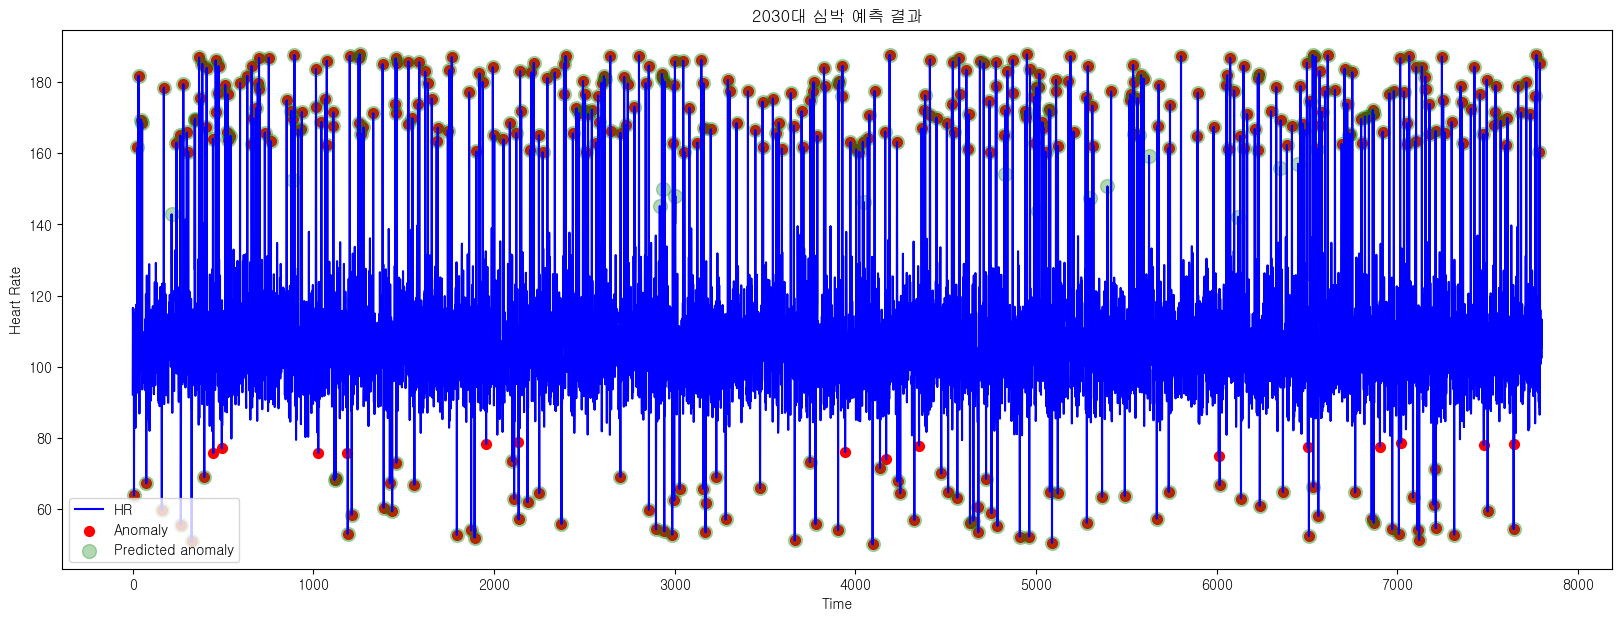

In [92]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(df_test2030)), df_test2030['heart_rate1'], label='HR', color='blue')
anomalies = df_test2030[df_test2030['event1'] == 1]

# 실제 이상치 시각화
plt.scatter(np.arange(len(df_test2030))[df_test2030['event1'] == 1], 
            df_test2030[df_test2030['event1'] == 1]['heart_rate1'],
            color='red', label='Anomaly', s=50)

# 예측된 이상치 시각화
plt.scatter(np.arange(len(df_test2030))[df_test2030['pred_y1'] == 1], 
            df_test2030[df_test2030['pred_y1'] == 1]['heart_rate1'],
            color='green', label='Predicted anomaly', s=100, alpha=0.3)

plt.ylabel('Heart Rate')
plt.title('2030대 심박 예측 결과')
plt.legend()
plt.show()

In [61]:
result2030 = pd.DataFrame()

for i in range(1,101):

    TP = len(df_test2030[(df_test2030[f'event{i}']==1)&(df_test2030[f'pred_y{i}']==1)])
    TN = len(df_test2030[(df_test2030[f'event{i}']==0)&(df_test2030[f'pred_y{i}']==0)])
    FN = len(df_test2030[(df_test2030[f'event{i}']==1)&(df_test2030[f'pred_y{i}']==0)])
    FP = len(df_test2030[(df_test2030[f'event{i}']==0)&(df_test2030[f'pred_y{i}']==1)])


    result_i2030 = performance(TP=TP, TN=TN, FP=FP, FN=FN, BETA=1)
    
    result2030 = pd.concat([result2030, result_i2030])

result2030.head()

,Sensitivity,Specificity,Accuracy,Precision,NPV,F_1 score
0,96.511628,99.810041,99.628205,96.736597,99.796500,96.623981
0,93.719807,99.905226,99.576923,98.227848,99.648886,95.920890
0,93.939394,99.918963,99.615385,98.412698,99.676637,96.124031
0,92.911392,99.891965,99.538462,97.866667,99.622896,95.324675
0,92.893401,99.797462,99.448718,96.062992,99.622591,94.451613


In [63]:
심박2030 = pd.DataFrame(index=['mean'])

심박2030['mean_sens'] = result2030['Sensitivity'].mean()
심박2030['std_sens'] = result2030['Sensitivity'].std()
심박2030['mean_spec'] = result2030['Specificity'].mean()
심박2030['std_spec'] = result2030['Specificity'].std()
심박2030['mean_accu'] = result2030['Accuracy'].mean()
심박2030['std_accu'] = result2030['Accuracy'].std()
심박2030['mean_precision'] = result2030['Precision'].mean()
심박2030['std_precision'] = result2030['Precision'].std()
심박2030['mean_npv'] = result2030['NPV'].mean()
심박2030['std_npv'] = result2030['NPV'].std()
심박2030['mean_F1_score'] = result2030['F_1 score'].mean()
심박2030['std_F1_score'] = result2030['F_1 score'].std()

심박2030

,mean_sens,std_sens,mean_spec,std_spec,mean_accu,std_accu,mean_precision,std_precision,mean_npv,std_npv,mean_F1_score,std_F1_score
mean,94.233722,1.230412,99.878596,0.044174,99.581538,0.068292,97.742497,0.804419,99.680329,0.066121,95.949619,0.697027


In [64]:
심박2030.to_csv('../result/로그정규/심박2030.csv')

## 3. 4050대

In [68]:
df4050 = pd.read_csv('../data/로그정규/심박_4050.csv', encoding='cp949')

print(df.shape)
df4050.head()

(24180, 201)


,time,heart_rate1,heart_rate2,heart_rate3,heart_rate4,heart_rate5,heart_rate6,heart_rate7,heart_rate8,heart_rate9,...,event91,event92,event93,event94,event95,event96,event97,event98,event99,event100
0,2024-01-01 09:00:00,97.496679,95.672346,100.678662,53.000000,105.679373,130.682394,88.561378,95.356306,106.860179,...,0,0,0,0,0,0,0,0,0,0
1,2024-01-01 09:01:00,123.889031,104.990027,95.802568,112.202551,108.467463,100.182643,107.510929,109.943174,106.137830,...,0,0,0,0,0,0,0,0,0,0
2,2024-01-01 09:02:00,92.797679,102.315435,117.042325,100.426224,167.000000,118.825076,112.011045,104.740314,104.112336,...,0,0,0,0,1,0,0,1,0,0
3,2024-01-01 09:03:00,108.247649,97.227464,88.855299,83.160290,113.293689,94.469131,101.635784,86.423819,94.174508,...,0,0,0,0,0,0,0,0,0,0
4,2024-01-01 09:04:00,108.564248,84.484594,98.753728,107.894950,110.441946,100.519210,124.745097,102.737285,109.245399,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# 분석
df_copy4050 = df4050.copy()

# 데이터를 df_train과 df_test로 분할
df_train4050 = df_copy4050[:16380]
df_test4050 = df_copy4050[16380:]

print(df_train4050.shape)
print(df_test4050.shape)

(16380, 201)
(7800, 201)


In [70]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series):
    result = adfuller(series)  # adf 검정
    if result[1] <= 0.05:  # p-value가 0.05 이하인 경우 정상성 만족
        return True
    else:
        return False

# 정상성 확인 및 결과 출력
non_stationary_variables = []  # 정상성을 만족하지 않는 변수들을 저장할 리스트

for i in range(1, 101):
    column_name = f'heart_rate{i}'
    # 함수 호출 결과를 바탕으로 정상성 검정
    if not adfuller_test(df_train4050[column_name]):
        non_stationary_variables.append(column_name)

# 정상성을 만족하지 않는 변수들 출력
if non_stationary_variables:
    print("정상성을 만족하지 않는 변수들:")
    for variable in non_stationary_variables:
        print(variable)
else:
    print("모든 변수가 정상성을 만족합니다.")

모든 변수가 정상성을 만족합니다.


In [71]:
from pmdarima.arima import auto_arima

start_time = time.time()

for i in range(1, 101):
    # Select the optimal p and q values for ARIMA model4050
    model4050 = auto_arima(df_train4050[f'heart_rate{i}'],test='adf',D=0 , seasonal=False, suppress_warnings=True, n_jobs=-1)
    p, d, q = model4050.order

    # ARIMA 모델 학습
    model4050 = ARIMA(df_train4050[f'heart_rate{i}'], order=(p, 0, q))
    result = model4050.fit()

    start_idx = 16380  # 테스트 데이터셋의 시작 인덱스
    end_idx = 16380 + len(df_test4050)  # 테스트 데이터셋의 끝 인덱스

    forecast = result.get_prediction(start=start_idx, end=end_idx, dynamic=True)

    # 신뢰구간과 예측값 할당
    forecast_ci = forecast.conf_int()

    # 데이터프레임에 신뢰구간 추가
    df_test4050[f'lower_{i}'] = forecast_ci.iloc[:, 0]
    df_test4050[f'upper_{i}'] = forecast_ci.iloc[:, 1]

    # 'pred_y{i}' 열이 이미 존재하는 경우 삭제하고 다시 추가 (insert 메서드 사용)
    if f'pred_y{i}' in df_test4050.columns:
        df_test4050.drop(columns=[f'pred_y{i}'], inplace=True)

    # 'pred_y{i}' 열을 'event{i}' 뒤에 생성
    df_test4050.insert(df_test4050.columns.get_loc(f'event{i}') + 1, f'pred_y{i}', np.where((df_test4050[f'heart_rate{i}'] < df_test4050[f'lower_{i}']) | (df_test4050[f'heart_rate{i}'] > df_test4050[f'upper_{i}']), 1, 0))

    # 'pred{i}', 'lower_{i}', 'upper_{i} 삭제
    if f'pred{i}' in df_test4050.columns:
        df_test4050.drop(columns=[f'pred{i}'], inplace=True)
    if f'lower_{i}' in df_test4050.columns:
        df_test4050.drop(columns=[f'lower_{i}'], inplace=True)
    if f'upper_{i}' in df_test4050.columns:
        df_test4050.drop(columns=[f'upper_{i}'], inplace=True)


end_time = time.time()
time_diff = end_time - start_time

time_diff = str(timedelta(seconds=time_diff))

print('코드 실행 시간: {}'.format(time_diff))

코드 실행 시간: 0:36:34.331915


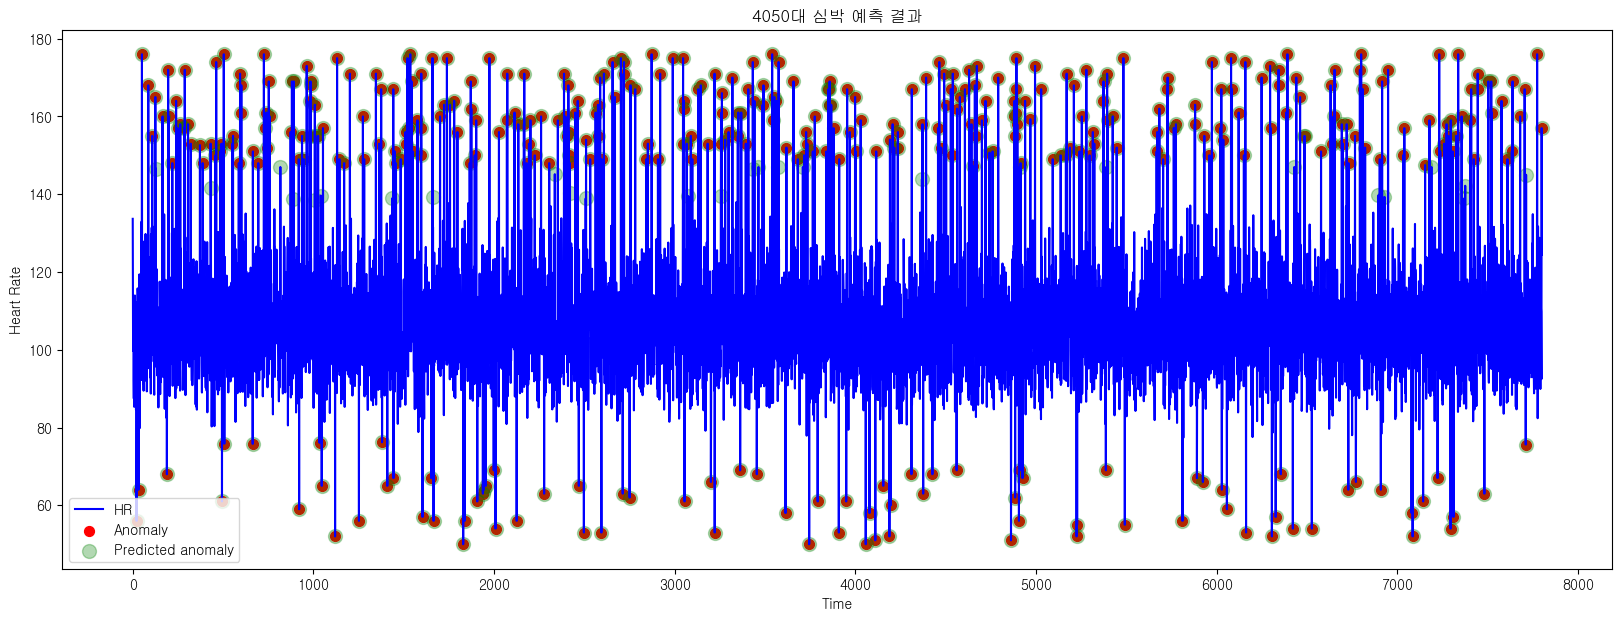

In [93]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(df_test4050)), df_test4050['heart_rate1'], label='HR', color='blue')
anomalies = df_test4050[df_test4050['event1'] == 1]
# 실제 이상치 시각화
plt.scatter(np.arange(len(df_test4050))[df_test4050['event1'] == 1], 
            df_test4050[df_test4050['event1'] == 1]['heart_rate1'],
            color='red', label='Anomaly', s=50)

# 예측된 이상치 시각화
plt.scatter(np.arange(len(df_test4050))[df_test4050['pred_y1'] == 1], 
            df_test4050[df_test4050['pred_y1'] == 1]['heart_rate1'],
            color='green', label='Predicted anomaly', s=100, alpha=0.3)

plt.title('Total Anomalies')
plt.xlabel('Time')
import matplotlib.pyplot as plt

# plt.axhline(y=72, color='red', label='Lower Bound', linewidth=3)
# plt.axhline(y=157, color='red', label='upper Bound', linewidth=3)
plt.ylabel('Heart Rate')
plt.title('4050대 심박 예측 결과')
plt.legend()
plt.show()

In [73]:
result4050 = pd.DataFrame()

for i in range(1,101):

    TP = len(df_test4050[(df_test4050[f'event{i}']==1)&(df_test4050[f'pred_y{i}']==1)])
    TN = len(df_test4050[(df_test4050[f'event{i}']==0)&(df_test4050[f'pred_y{i}']==0)])
    FN = len(df_test4050[(df_test4050[f'event{i}']==1)&(df_test4050[f'pred_y{i}']==0)])
    FP = len(df_test4050[(df_test4050[f'event{i}']==0)&(df_test4050[f'pred_y{i}']==1)])


    result_i4050 = performance(TP=TP, TN=TN, FP=FP, FN=FN, BETA=1)
    
    result4050 = pd.concat([result4050, result_i4050])

result4050.head()

,Sensitivity,Specificity,Accuracy,Precision,NPV,F_1 score
0,100.000000,99.634691,99.653846,93.807339,100.000000,96.804734
0,99.514563,99.566865,99.564103,92.760181,99.972819,96.018735
0,99.234694,99.676026,99.653846,94.188862,99.959388,96.645963
0,99.731903,99.649926,99.653846,93.467337,99.986490,96.498054
0,99.469496,99.582379,99.576923,92.364532,99.972951,95.785441


In [74]:
심박4050 = pd.DataFrame(index=['mean'])

심박4050['mean_sens'] = result4050['Sensitivity'].mean()
심박4050['std_sens'] = result4050['Sensitivity'].std()
심박4050['mean_spec'] = result4050['Specificity'].mean()
심박4050['std_spec'] = result4050['Specificity'].std()
심박4050['mean_accu'] = result4050['Accuracy'].mean()
심박4050['std_accu'] = result4050['Accuracy'].std()
심박4050['mean_precision'] = result4050['Precision'].mean()
심박4050['std_precision'] = result4050['Precision'].std()
심박4050['mean_npv'] = result4050['NPV'].mean()
심박4050['std_npv'] = result4050['NPV'].std()
심박4050['mean_F1_score'] = result4050['F_1 score'].mean()
심박4050['std_F1_score'] = result4050['F_1 score'].std()

심박4050

,mean_sens,std_sens,mean_spec,std_spec,mean_accu,std_accu,mean_precision,std_precision,mean_npv,std_npv,mean_F1_score,std_F1_score
mean,99.502262,0.41392,99.617786,0.0694,99.612179,0.066764,93.211389,1.182763,99.973873,0.021517,96.249817,0.653391


In [75]:
심박4050.to_csv('../result/로그정규/심박4050.csv')

## 3. 6070대

In [76]:
df6070 = pd.read_csv('../data/로그정규/심박_6070.csv', encoding='cp949')

print(df.shape)
df6070.head(2)

(24180, 201)


,time,heart_rate1,heart_rate2,heart_rate3,heart_rate4,heart_rate5,heart_rate6,heart_rate7,heart_rate8,heart_rate9,...,event91,event92,event93,event94,event95,event96,event97,event98,event99,event100
0,2024-01-01 09:00:00,100.552583,90.631228,90.304552,99.148547,96.394693,100.578453,94.944473,104.926710,96.883610,...,0,0,0,0,0,1,0,0,0,0
1,2024-01-01 09:01:00,102.697944,101.353462,90.015000,93.630333,104.175350,96.465290,107.683246,96.756633,97.558345,...,0,0,0,0,0,0,0,0,0,0


In [77]:
# 분석
df_copy6070 = df6070.copy()

# 데이터를 df_train과 df_test로 분할
df_train6070 = df_copy6070[:16380]
df_test6070 = df_copy6070[16380:]

print(df_train6070.shape)
print(df_test6070.shape)

(16380, 201)
(7800, 201)


In [79]:
from pmdarima.arima import auto_arima

start_time = time.time()

for i in range(1, 101):
    # Select the optimal p and q values for ARIMA model6070
    model6070 = auto_arima(df_train6070[f'heart_rate{i}'],test='adf',D=0 , seasonal=False, suppress_warnings=True, n_jobs=-1)
    p, d, q = model6070.order

    # ARIMA 모델 학습
    model6070 = ARIMA(df_train6070[f'heart_rate{i}'], order=(p, 0, q))
    result = model6070.fit()

    start_idx = 16380  # 테스트 데이터셋의 시작 인덱스
    end_idx = 16380 + len(df_test6070)  # 테스트 데이터셋의 끝 인덱스

    forecast = result.get_prediction(start=start_idx, end=end_idx, dynamic=True)

    # 신뢰구간과 예측값 할당
    forecast_ci = forecast.conf_int()

    # 데이터프레임에 신뢰구간 추가
    df_test6070[f'lower_{i}'] = forecast_ci.iloc[:, 0]
    df_test6070[f'upper_{i}'] = forecast_ci.iloc[:, 1]

    # 'pred_y{i}' 열이 이미 존재하는 경우 삭제하고 다시 추가 (insert 메서드 사용)
    if f'pred_y{i}' in df_test6070.columns:
        df_test6070.drop(columns=[f'pred_y{i}'], inplace=True)

    # 'pred_y{i}' 열을 'event{i}' 뒤에 생성
    df_test6070.insert(df_test6070.columns.get_loc(f'event{i}') + 1, f'pred_y{i}', np.where((df_test6070[f'heart_rate{i}'] < df_test6070[f'lower_{i}']) | (df_test6070[f'heart_rate{i}'] > df_test6070[f'upper_{i}']), 1, 0))

    # 'pred{i}', 'lower_{i}', 'upper_{i} 삭제
    if f'pred{i}' in df_test6070.columns:
        df_test6070.drop(columns=[f'pred{i}'], inplace=True)
    if f'lower_{i}' in df_test6070.columns:
        df_test6070.drop(columns=[f'lower_{i}'], inplace=True)
    if f'upper_{i}' in df_test6070.columns:
        df_test6070.drop(columns=[f'upper_{i}'], inplace=True)


end_time = time.time()
time_diff = end_time - start_time

time_diff = str(timedelta(seconds=time_diff))

print('코드 실행 시간: {}'.format(time_diff))

코드 실행 시간: 0:26:50.800896


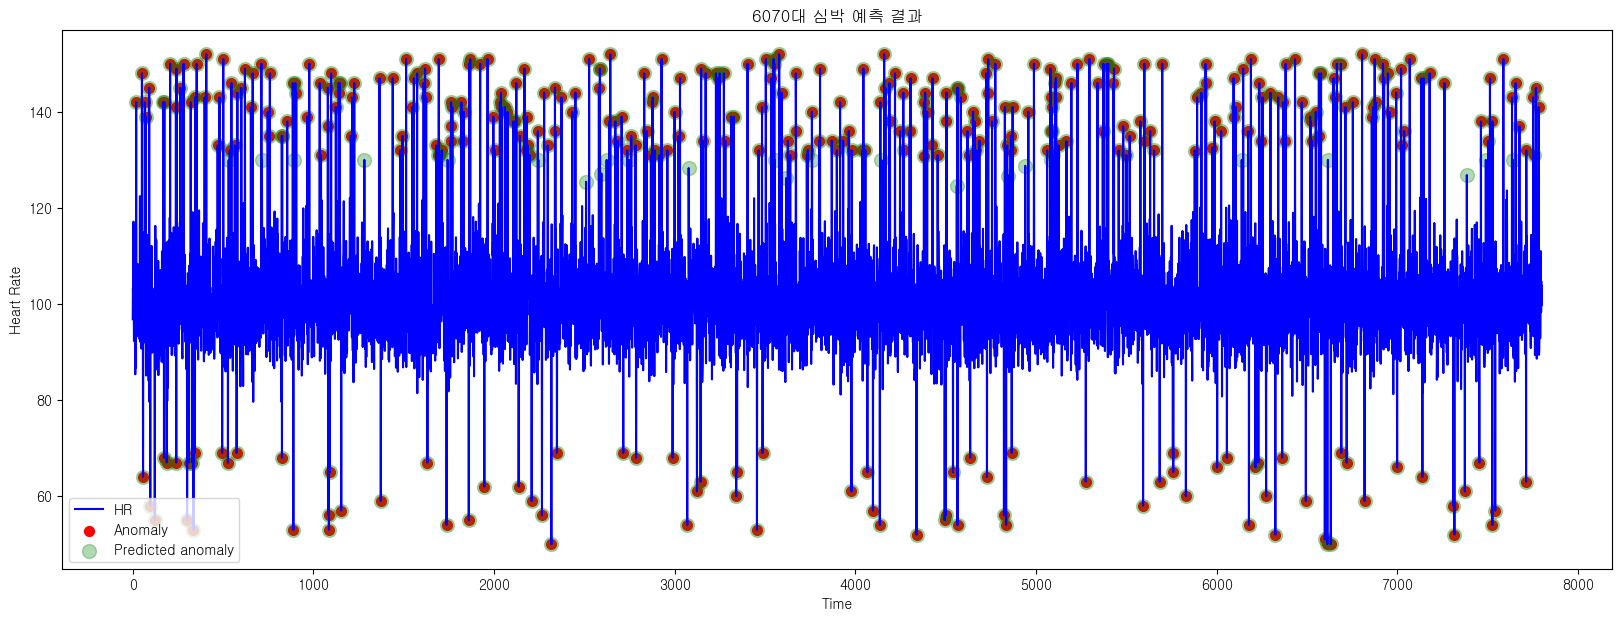

In [94]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(df_test6070)), df_test6070['heart_rate1'], label='HR', color='blue')
anomalies = df_test6070[df_test6070['event1'] == 1]
# 실제 이상치 시각화
plt.scatter(np.arange(len(df_test6070))[df_test6070['event1'] == 1], 
            df_test6070[df_test6070['event1'] == 1]['heart_rate1'],
            color='red', label='Anomaly', s=50)

# 예측된 이상치 시각화
plt.scatter(np.arange(len(df_test6070))[df_test6070['pred_y1'] == 1], 
            df_test6070[df_test6070['pred_y1'] == 1]['heart_rate1'],
            color='green', label='Predicted anomaly', s=100, alpha=0.3)

plt.title('Total Anomalies')
plt.xlabel('Time')
import matplotlib.pyplot as plt

# plt.axhline(y=72, color='red', label='Lower Bound', linewidth=3)
# plt.axhline(y=157, color='red', label='upper Bound', linewidth=3)
plt.ylabel('Heart Rate')
plt.title('6070대 심박 예측 결과')
plt.legend()
plt.show()

In [81]:
result6070 = pd.DataFrame()

for i in range(1,101):

    TP = len(df_test6070[(df_test6070[f'event{i}']==1)&(df_test6070[f'pred_y{i}']==1)])
    TN = len(df_test6070[(df_test6070[f'event{i}']==0)&(df_test6070[f'pred_y{i}']==0)])
    FN = len(df_test6070[(df_test6070[f'event{i}']==1)&(df_test6070[f'pred_y{i}']==0)])
    FP = len(df_test6070[(df_test6070[f'event{i}']==0)&(df_test6070[f'pred_y{i}']==1)])


    result_i6070 = performance(TP=TP, TN=TN, FP=FP, FN=FN, BETA=1)
    
    result6070 = pd.concat([result6070, result_i6070])

result6070.head()

,Sensitivity,Specificity,Accuracy,Precision,NPV,F_1 score
0,100.0,99.676157,99.692308,94.188862,100.0,97.007481
0,100.0,99.756790,99.769231,95.683453,100.0,97.794118
0,100.0,99.595742,99.615385,92.665037,100.0,96.192893
0,100.0,99.690902,99.705128,93.979058,100.0,96.896086
0,100.0,99.622946,99.641026,93.034826,100.0,96.391753


In [82]:
심박6070 = pd.DataFrame(index=['mean'])

심박6070['mean_sens'] = result6070['Sensitivity'].mean()
심박6070['std_sens'] = result6070['Sensitivity'].std()
심박6070['mean_spec'] = result6070['Specificity'].mean()
심박6070['std_spec'] = result6070['Specificity'].std()
심박6070['mean_accu'] = result6070['Accuracy'].mean()
심박6070['std_accu'] = result6070['Accuracy'].std()
심박6070['mean_precision'] = result6070['Precision'].mean()
심박6070['std_precision'] = result6070['Precision'].std()
심박6070['mean_npv'] = result6070['NPV'].mean()
심박6070['std_npv'] = result6070['NPV'].std()
심박6070['mean_F1_score'] = result6070['F_1 score'].mean()
심박6070['std_F1_score'] = result6070['F_1 score'].std()

심박6070

,mean_sens,std_sens,mean_spec,std_spec,mean_accu,std_accu,mean_precision,std_precision,mean_npv,std_npv,mean_F1_score,std_F1_score
mean,100.0,0.0,99.657783,0.070927,99.674359,0.067349,93.706101,1.191885,100.0,0.0,96.746928,0.635619


In [83]:
심박6070.to_csv('../result/로그정규/심박6070.csv')